In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_gpu = torch.cuda.is_available()
print(torch.__version__)
print(device)

2.0.0
cuda:0


# Initialize for CPU & GPU

In [2]:
if use_gpu:
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/torch-geometric
#     !pip install torch_geometric_temporal  
else:
    !pip install /kaggle/input/pytorch-geometric-cpu/torch_scatter-2.1.1pt20cpu-cp310-cp310-linux_x86_64.whl
    !pip install /kaggle/input/pytorch-geometric-cpu/torch_sparse-0.6.17pt20cpu-cp310-cp310-linux_x86_64.whl
    !pip install /kaggle/input/pytorch-geometric-cpu/torch_cluster-1.6.1pt20cpu-cp310-cp310-linux_x86_64.whl
    !pip install /kaggle/input/pytorch-geometric-cpu/torch_spline_conv-1.2.2pt20cpu-cp310-cp310-linux_x86_64.whl
    !pip install /kaggle/input/pytorch-geometric-cpu/torch_geometric-2.3.1-py3-none-any.whl
#     !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
#     !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
#     !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
#     !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
#     !pip install torch_spline_conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
#     !pip install git+https://github.com/pyg-team/pytorch_geometric.git
#     !pip install torch_geometric_temporal

Looking in links: file:///kaggle/input/torch-geometric
Processing /kaggle/input/torch-geometric/torch_scatter-2.1.1-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_sparse-0.6.17-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_cluster-1.6.1-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_spline_conv-1.2.2-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_geometric-2.3.1-py3-none-any.whl


# Import

In [3]:
import numpy as np
import pandas as pd
import os
import re
import json
import random
from scipy.special import perm
from itertools import combinations,chain
from typing import List, Union
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import pickle
import time
from torch import nn
from torch.nn import Linear as Lin
from torch.nn import ReLU, LeakyReLU
from torch.nn import Sequential as Seq
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.data import Batch
from torch import autograd
from torch_geometric.nn.models import InnerProductDecoder
from torch_geometric.utils import to_dense_adj

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

from texttable import Texttable

# DataLoader

In [4]:
Edge_Flag = List[Union[np.ndarray, None]]
Edge_Index = List[Union[np.ndarray, None]]
Edge_Attr = List[Union[np.ndarray, None]]

Node_Flag = List[Union[np.ndarray, None]]
Node_Index = List[Union[np.ndarray, None]]
Node_Attr = List[Union[np.ndarray, None]]



class GraphSignal(object):
    # dynamic node static node attr dynamic edge and edge attr
    def __init__(
        self,
        edge_flag: Edge_Flag,
        edge_index: Edge_Index,
        edge_attr: Edge_Attr,
        node_flag: Node_Flag,
        node_index: Node_Index,
        node_attr: Node_Attr,
        ts_list: List,
        path: str,
    ):
        
        self.raw_edge_flag = torch.LongTensor(edge_flag[:-1])
        self.raw_edge_index = torch.LongTensor(edge_index).T
        self.raw_edge_attr = edge_attr
        self.raw_node_attr = node_attr 
        self.node_flag = torch.LongTensor(node_flag[:-1])
        self.node_index = torch.LongTensor(node_index)
        
        self.ts_list = ts_list
        
        self.path = path
        
        self.node_attr = None
        self.edge_flag = None
        self.edge_index = None
        
        self.y = None
        
        self._set_snapshot_count()
        self._set_node_count()

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.ts_list)
    
    def _set_node_count(self):
        self.node_count = self.raw_node_attr.shape[0]
    
    def encode_edge_attr(self, enocder):
        self.edge_attr_encoded = torch.FloatTensor(enocder.transform(self.raw_edge_attr))
        
    def encode_node_attr(self, enocder):
        self.node_attr_encoded = torch.FloatTensor(enocder.transform(self.raw_node_attr))
        
    def extend_node_attr(self):
        if self.edge_attr_encoded is None:
            print("Edge Attr Need to be Encoded!")
            raise
        node_index = self.node_index
        node_attr = self.node_attr_encoded.index_select(dim=0,index=self.node_index)
        node_flag = self.node_flag
        
        edge_index = self.raw_edge_index
        edge_attr = self.edge_attr_encoded
        edge_flag = self.raw_edge_flag
        
        node_index_split = torch.tensor_split(node_index, node_flag)
        node_attr_split = torch.tensor_split(node_attr, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        edge_attr_split = torch.tensor_split(edge_attr, edge_flag)

        base = 0
        new_node_attr = []
        new_edge_flag = []
        new_edge_index = []
        
        for i_snapshot in range(self.snapshot_count):
            _node_index = node_index_split[i_snapshot]
            _node_attr = node_attr_split[i_snapshot]
            _edge_index = edge_index_split[i_snapshot]
            _edge_attr = edge_attr_split[i_snapshot]

            if _edge_index.shape[1] != _edge_attr.shape[0]:
                print(i_snapshot, edge_index.shape, _edge_attr.shape)
                raise
            if _edge_index.shape[1] > 0:
                index_dict = {}
                for i_edge in range(_edge_index.shape[1]):
                    index_tuple = tuple(_edge_index[:,i_edge].tolist())
                    if index_tuple in index_dict:
                        index_dict[index_tuple] += [i_edge]
                    else:
                        index_dict[index_tuple] = [i_edge]

                _new_edge_index = []
                _new_edge_attr = []
                for key in index_dict.keys():
                    _new_edge_index.append(key)
                    _new_edge_attr.append(torch.sum(_edge_attr.index_select(0, torch.LongTensor(index_dict[key])),dim=0).unsqueeze(0))

                _new_edge_index = torch.LongTensor(_new_edge_index).T
                _new_edge_attr = torch.cat(_new_edge_attr,dim=0)
                
                base += _new_edge_index.shape[1]
                new_edge_index.append(_new_edge_index)

#                 _source_attr = torch.zeros((_node_attr.shape[0], _new_edge_attr.shape[1])).to(device)
#                 _target_attr = torch.zeros((_node_attr.shape[0], _new_edge_attr.shape[1])).to(device)
#                 _source_attr.index_add_(0, _new_edge_index[0], _new_edge_attr)
#                 _target_attr.index_add_(0, _new_edge_index[1], _new_edge_attr)
#                 new_node_attr.append(torch.cat([_node_attr,_source_attr,_target_attr], dim=1))

                _node_attr_extend = torch.zeros((_node_attr.shape[0], _new_edge_attr.shape[1]))
                _node_attr_extend.index_add_(0, _new_edge_index[0], _new_edge_attr)
                _node_attr_extend.index_add_(0, _new_edge_index[1], _new_edge_attr)
                new_node_attr.append(torch.cat([_node_attr,_node_attr_extend], dim=1)) 
                
            new_edge_flag.append(base)
        
        self.node_attr = torch.cat(new_node_attr, dim=0)
        self.edge_flag = torch.LongTensor(new_edge_flag)
        self.edge_index = torch.cat(new_edge_index,dim=1)
    
    def remove_init_stop(self, threshold, period):
        node_index = self.node_index
        node_attr = self.node_attr
        node_flag = self.node_flag

        edge_index = self.edge_index
        edge_flag = self.edge_flag
        
        raw_edge_index = self.raw_edge_index
        raw_edge_attr = self.raw_edge_attr
        raw_edge_flag = self.raw_edge_flag

        node_index_split = torch.tensor_split(node_index, node_flag)
        node_attr_split = torch.tensor_split(node_attr, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        
        raw_edge_index_split = torch.tensor_split(raw_edge_index, raw_edge_flag, dim=1)
        raw_edge_attr_split = np.split(raw_edge_attr, raw_edge_flag)

        i_init = None
        i_stop = None
        for i_snapshot, node_num in enumerate(torch.diff(self.node_flag)):
            if node_num > threshold:
                i_init = i_snapshot+1
                break

        for i_snapshot, node_num in enumerate(torch.flip(torch.diff(self.node_flag),dims=[0])):
            if node_num > threshold:
                i_stop = self.node_flag.shape[0]-1-i_snapshot
                break
        
        new_node_attr = torch.cat(node_attr_split[i_init+1+period:i_stop-period],dim=0)
        new_node_index = torch.cat(node_index_split[i_init+1+period:i_stop-period],dim=0)
        new_edge_index = torch.cat(edge_index_split[i_init+1+period:i_stop-period],dim=1)
        new_raw_edge_index = torch.cat(raw_edge_index_split[i_init+1+period:i_stop-period], dim=1)
        new_raw_edge_attr = np.concatenate(raw_edge_attr_split[i_init+1+period:i_stop-period])

        new_node_flag = node_flag[i_init+period+1:i_stop-period-1]-node_flag[i_init+period]
        new_edge_flag = edge_flag[i_init+period+1:i_stop-period-1]-edge_flag[i_init+period]
        new_raw_edge_flag = raw_edge_flag[i_init+period+1:i_stop-period-1]-raw_edge_flag[i_init+period]
        
        self.node_attr = F.tanh(new_node_attr)
        self.node_index = new_node_index
        self.edge_index = new_edge_index
        self.raw_edge_attr = new_raw_edge_attr
        self.raw_edge_index = new_raw_edge_index
        
        self.node_flag = new_node_flag
        self.edge_flag = new_edge_flag
        self.raw_edge_flag = new_raw_edge_flag
        
        self.ts_list = self.ts_list[i_init+1+period:i_stop-period]
        
        self._set_snapshot_count()
    
    def annotation2y(self, annotation, interval, overlap, offset= -30):
        ts_list = self.ts_list
        y = torch.zeros(self.snapshot_count, dtype=torch.long)
        for i_ts, ts in enumerate(ts_list):
            if ts < float(annotation[1])+offset and float(annotation[1])+offset <= ts+interval-overlap: 
                y[i_ts] = 1
        self.y = y
    
    def to(self,device):
        self.node_attr = self.node_attr.to(device)
        self.node_index = self.node_index.to(device)
        self.edge_index = self.edge_index.to(device)
    
    def get_adj_list(self):
        edge_index = self.edge_index
        edge_flag = self.edge_flag
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        adj_list = [torch.clamp(to_dense_adj(_edge_index)[0], min=0, max=1) for _edge_index in edge_index_split]
        return adj_list

    def _get_edge_index(self, time_index: int):
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_index = self.edge_index[:,_start:_end]
        return _edge_index

    def _get_edge_attr(self, time_index: int):
        if self.edge_attr_encoded is None:
            print("Edge Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_attr = self.edge_attr_encoded[_start:_end]
        return _edge_attr
    
    def _get_node_index_attr(self, time_index: int):
        if self.node_attr_encoded is None:
            print("Node Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.node_flag[time_index-1]
        _end = self.node_flag[time_index]
        _node_index = self.node_index[_start:_end]
        _node_attr = self.node_attr_encoded[_node_index]
        return _node_index,_node_attr
    
    def _get_timestamp(self, time_index: int):
        _timestamp = self.ts_list[time_index]
        return _timestamp


    def __getitem__(self, time_index: int):
        edge_index = self._get_edge_index(time_index)
        edge_attr = self._get_edge_attr(time_index)
        node_index,node_attr = self._get_node_index_attr(time_index)
        _timestamp = self._get_timestamp(time_index)

        snapshot = Data(
            edge_index=edge_index,
            edge_attr=edge_attr,
            node_index=node_index,
            node_attr=node_attr,
            timestamp=_timestamp
        )
        return snapshot

    def __next__(self):
        if self.t < self.snapshot_count:
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self
    
    def __len__(self):
        return self.snapshot_count


class GraphDatasetLoader(object):
    def __init__(self,input_path=""):
        self.input_path = input_path
        self._read_data()
    
    def _read_data(self):
        self._dataset = np.load(self.input_path)

    def get_dataset(self): # -> DynamicGraphTemporalSignal:
        dataset = GraphSignal(
            edge_flag = self._dataset['edge_flag'],
            edge_index = self._dataset['edge_index'],
            edge_attr = self._dataset['edge_attr'],
            node_flag = self._dataset['node_flag'],
            node_index = self._dataset['node_index'],
            node_attr = self._dataset['node_attr'],
            ts_list = self._dataset['timestamp'],
            path = self.input_path
        )
        return dataset

In [5]:
data_dir_0 = '/kaggle/input/dissertation-data'
data_dir_1 = '2021-09-11-umbrella-experiment-32run-fran'


signals = []
annotation = []
with open(os.path.join(data_dir_0, data_dir_1, "annotated.json")) as f:
    annotated_dict = json.load(f)

for data_dir_2 in os.listdir(os.path.join(data_dir_0, data_dir_1)):
    if data_dir_2 == "annotated.json":
        continue
    r = re.compile(".*.npz")
    graph_files = list(filter(r.match, os.listdir(os.path.join(data_dir_0, data_dir_1, data_dir_2))))

    if len(graph_files) > 1:
        print("Multiple Graph Files!")
        raise
    if len(graph_files) == 0:
        print("Not Found Graph File!")
        continue

    dataloader = GraphDatasetLoader(os.path.join(data_dir_0, data_dir_1, data_dir_2, graph_files[0]))
    signal = dataloader.get_dataset()
    signals.append(signal)
    annotation.append(annotated_dict[data_dir_2])

# split train and test dataset
signals_train, signals_test, annotation_train, annotation_test = train_test_split(signals, annotation, test_size=0.2, random_state=1)
signals_train, signals_val, annotation_train, annotation_val = train_test_split(signals_train, annotation_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [6]:
_interval = 60
_overlap = 30

node_num_list = []
for signal in signals_train:
    node_num_list += torch.diff(signal.node_flag).tolist()
    
threshold = np.median(node_num_list)
period = 3

print(f"Threshold = {threshold} Period = {period}")

node_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
node_attr_encoder = node_attr_encoder.fit(np.concatenate([sample.raw_node_attr for sample in signals_train]))

edge_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
edge_attr_encoder = edge_attr_encoder.fit(np.concatenate([sample.raw_edge_attr for sample in signals_train]))

for i_signal, (signal, annotation) in enumerate(zip(signals_train, annotation_train)):
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)
    signal.extend_node_attr()
    signal.remove_init_stop(threshold, period)
    signal.annotation2y(annotation, _interval, _overlap)
    
for i_signal, (signal, annotation) in enumerate(zip(signals_val, annotation_val)):
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)
    signal.extend_node_attr()
    signal.remove_init_stop(threshold, period)
    signal.annotation2y(annotation, _interval, _overlap)

# for signal in signals_train:
#     signal.to(device)

# for signal in signals_val:
#     signal.to(device)
    
    
IN_CHANNELS = signals_train[0].node_attr.shape[1]
# EDGE_CHANNELS = signals_train[0].edge_attr_encoded.shape[1]

Threshold = 77.0 Period = 3


# Multi-Layer GraphConv

In [7]:
class MultiGraphConv(torch.nn.Module):
    def __init__(
        self, 
        channels, 
    ):
        super().__init__()
         
        self.convs = nn.ModuleList()
        
        net1 = Seq(
            Lin(channels, channels),
            LeakyReLU(),
            Lin(channels, channels*2),
            LeakyReLU(),
            Lin(channels*2, channels*2),
            LeakyReLU(),
        )
        conv1 = GINConv(net1,train_eps=True)
        self.convs.append(conv1)
        
        net2 = Seq(
            Lin(channels*2, channels*2),
            LeakyReLU(),
            Lin(channels*2, channels),
            LeakyReLU(),
            Lin(channels, channels),
            LeakyReLU(),
        )
        conv2 = GINConv(net2,train_eps=True)
        self.convs.append(conv2)
        

    def forward(self, x, edge_index):
        out = x
        for conv in self.convs:
            out = conv(x=out, edge_index=edge_index)
        return out

# Graph RNN Operator

In [8]:
class GraphGRU(torch.nn.Module):
    def __init__(
        self,
        channels: int,
        bias: bool = True,
    ):
        super().__init__()

        self.channels = channels
        self.bias = bias
        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):

        self.conv_x_z = MultiGraphConv(channels = self.channels)

        self.conv_h_z = MultiGraphConv(channels = self.channels)
        
    def _create_reset_gate_parameters_and_layers(self):

        self.conv_x_r = MultiGraphConv(channels = self.channels)

        self.conv_h_r = MultiGraphConv(channels = self.channels)

    def _create_candidate_state_parameters_and_layers(self):

        self.conv_x_h = MultiGraphConv(channels = self.channels)

        self.conv_h_h = MultiGraphConv(channels = self.channels)

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return H

    def _calculate_update_gate(self, X, edge_index, H):
        Z = self.conv_x_z(X, edge_index)
        Z = Z + self.conv_h_z(H, edge_index)
        Z = torch.sigmoid(Z)
        return Z

    def _calculate_reset_gate(self, X, edge_index, H):
        R = self.conv_x_r(X, edge_index)
        R = R + self.conv_h_r(H, edge_index)
        R = torch.sigmoid(R)
        return R

    def _calculate_candidate_state(self, X, edge_index, H, R):
        H_tilde = self.conv_x_h(X, edge_index)
        H_tilde = H_tilde + self.conv_h_h(H * R, edge_index)
        H_tilde = torch.tanh(H_tilde)
        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde
        return H

    def forward(
            self,
            X: torch.FloatTensor,
            edge_index: torch.LongTensor,
            H: torch.FloatTensor = None,
        ) -> torch.FloatTensor:
        H = self._set_hidden_state(X, H)
        Z = self._calculate_update_gate(X, edge_index, H)
        R = self._calculate_reset_gate(X, edge_index, H)
        H_tilde = self._calculate_candidate_state(X, edge_index, H, R)
        H = self._calculate_hidden_state(Z, H, H_tilde)
        return H

# Graph RNN Layer

In [9]:
class GraphGRULayer(torch.nn.Module):
    def __init__(
        self,
        channels: int,
        bias: bool = True,
    ):
        super().__init__()
        self.gru = GraphGRU(
            channels = channels,
            bias = bias
        )
        
        self.channels = channels
        
    def forward(
        self,
        X: torch.FloatTensor,
        node_index: torch.LongTensor,
        node_flag: torch.LongTensor,
        edge_index: torch.LongTensor,
        edge_flag: torch.LongTensor,
        direction: bool # True for Forward; False for Backward
    ) -> torch.FloatTensor:
        
        X_split = torch.tensor_split(X, node_flag)
        node_index_split = torch.tensor_split(node_index, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        
#         print(X_split[0].device)
#         print(node_index_split[0].device)
#         print(edge_index_split[0].device)
             
        pre_hidden = None
        
        outs = []
        if direction:
            snapshot_index = range(len(X_split))
        else:
            snapshot_index = range(len(X_split)-1,-1,-1)
            
        for i_snapshot in snapshot_index:
            _X = X_split[i_snapshot]
            _node_index = node_index_split[i_snapshot]
            _edge_index = edge_index_split[i_snapshot]
            
            curr_hidden = torch.zeros(_X.shape[0],self.channels).to(_X.device)
            if i_snapshot != 0:
                pre_node_index = node_index_split[i_snapshot-1]
                # Solution from https://discuss.pytorch.org/t/find-indexes-of-elements-from-one-tensor-that-matches-in-another-tensor/147482/2
                _index = (node_index_split[i_snapshot-1].unsqueeze(1) == node_index_split[i_snapshot].unsqueeze(0)).nonzero() 
                curr_hidden.index_add_(0, _index[:,1], torch.index_select(pre_hidden,0, _index[:,0]))

            new_hidden = self.gru(_X, _edge_index, curr_hidden)
            pre_hidden = new_hidden
            outs.append(new_hidden)
        if direction:
            H = torch.cat(outs)
        else:
            H = torch.cat(outs[::-1])
        return H

# TGAE Model

In [10]:
class TGAE(torch.nn.Module): # Not Heterogeneous
    def __init__(
        self, 
        in_channels, 
        out_channels, 
        embed_layers,  
        decide_layers,
    ):
        super(TGAE, self).__init__()
        
        # Encoder Embeding
#         layers = [torch.nn.BatchNorm1d(in_channels)]
        layers = []
        pre_h_num = in_channels
        for h_num in embed_layers[:-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,embed_layers[-1]))
        self.embed_net = Seq(*layers)
                
        self.encoder_gru = GraphGRULayer(channels=embed_layers[-1])

        layers = []
        pre_h_num = embed_layers[-1]
        for h_num in decide_layers:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,out_channels))
#         layers.append(torch.nn.Sigmoid())
        self.decide_net = Seq(*layers)
        
        # Decoder
        self.decoder = InnerProductDecoder()
        

    def forward(self, x, node_index, node_flag, edge_index, edge_flag):
        # Encoder
        out = self.embed_net(x)
        
        # GNN layer
        h_encoder = self.encoder_gru(out, node_index, node_flag, edge_index, edge_flag, True) 
        
        out = self.decide_net(h_encoder)

        return out
    

# Create Model 

In [11]:
model = TGAE(
    in_channels=IN_CHANNELS, 
    out_channels=32, 
    embed_layers=[128,256,512,256],
    decide_layers=[512,256,128],
)

# model = torch.load(
#     "/kaggle/input/tgae-model-saved/TGAE2_GRUConv_50_5.7319_5.8686.model",
#     map_location=torch.device(device)
# )

loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

model = model.to(device)
loss_f = loss_f.to(device)
print(model)

TGAE(
  (embed_net): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=63, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=256, out_features=512, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=512, out_features=256, bias=True)
  )
  (encoder_gru): GraphGRULayer(
    (gru): GraphGRU(
      (conv_x_z): MultiGraphConv(
        (convs): ModuleList(
          (0): GINConv(nn=Sequential(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
            (2): Linear(in_features=256, out_features=512, bias=True)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Linear(in_features=512, out_features=512, bias=True)
            (5): Le

In [12]:
# print(len(signals_train))
# data_list_2D = [[] for _ in range(MIN_LEN)]
# _node_index_list = [[] for _ in range(MIN_LEN)]
# base_node_index = 0
# for i_signal in np.random.randint(low=0, high=len(signals_train), size=BATCH_SIZE, dtype=int):
#     signal = signals_train[i_signal]
#     node_attr_split = signal.node_attr.tensor_split(signal.node_flag)
#     node_index_split = signal.node_index.tensor_split(signal.node_flag)
#     edge_index_split = signal.edge_index.tensor_split(signal.edge_flag, dim=1)

#     if signal.snapshot_count-MIN_LEN != 0:
#         _start = np.random.randint(low=0, high=signal.snapshot_count-MIN_LEN+1)
#     else:
#         _start = 0
#     for i_series, i_snapshot in enumerate(range(_start, _start+MIN_LEN)):
#         data = Data(
#             x = node_attr_split[i_snapshot],
#             edge_index = edge_index_split[i_snapshot],
#             node_index = node_index_split[i_snapshot],
#             node_count =  signal.node_count
#         )
#         data_list_2D[i_series].append(data)
        
#         _node_index_list[i_series].append(node_index_split[i_snapshot]+base_node_index)
#     base_node_index += signal.node_count
# node_index_list = [torch.cat(_node_index, dim=0) for _node_index in _node_index_list]  

In [13]:
# check batch works
# normal_hidden_list = [[] for _ in range(MIN_LEN)]
# pre_hidden_list = None
# pre_node_index_list = None
# for i_series in range(MIN_LEN):
#     _hidden_list = []
#     _node_index_list = []
#     for i_batch in range(BATCH_SIZE):
#         if pre_hidden_list is not None:
#             _hidden = torch.zeros((data_list_2D[i_series][i_batch].node_count,data_list_2D[i_series][i_batch].x.shape[1]))            
#             _hidden.index_add_(0,pre_node_index_list[i_batch], pre_hidden_list[i_batch])
#             normal_hidden_list[i_series].append(torch.index_select(_hidden,0,data_list_2D[i_series][i_batch].node_index))
        
#         _hidden_list.append(data_list_2D[i_series][i_batch].x)
#         _node_index_list.append(data_list_2D[i_series][i_batch].node_index)
    
#     pre_hidden_list = _hidden_list
#     pre_node_index_list = _node_index_list
# normal_hidden_list = [torch.cat(_hiddens) for _hiddens in normal_hidden_list[1:]]

# batch_list = [Batch.from_data_list(data_list) for data_list in data_list_2D]
# batch_hidden_list = []
# pre_hidden = None
# pre_node_index = None
# for i_series in range(MIN_LEN):
#     if pre_hidden is not None:
#         _hidden = torch.zeros((batch_list[i_series].x.shape))
#         # Solution from https://discuss.pytorch.org/t/find-indexes-of-elements-from-one-tensor-that-matches-in-another-tensor/147482/2
#         _index = (pre_node_index.unsqueeze(1) == node_index_list[i_series].unsqueeze(0)).nonzero() 
#         _hidden.index_add_(0, _index[:,1], torch.index_select(pre_hidden,0, _index[:,0]))
#         batch_hidden_list.append(_hidden)
#     pre_hidden = batch_list[i_series].x
#     pre_node_index = node_index_list[i_series]

# torch.all(torch.eq(normal_hidden_list[2], batch_hidden_list[2]))

# Batch Signal

In [14]:
# Concat Batchs to from BatchSignal
class BatchSignal():
    def __init__(self, signals, batch_size, seq_len):   
        data_list_2D = [[] for _ in range(seq_len)]
        node_index_split_list = [[] for _ in range(seq_len)]
        base_node_index = 0
        
        self.batch_index = [[i_signal, 0] for i_signal in np.random.randint(low=0, high=len(signals), size=batch_size, dtype=int)]

        for i_batch, (i_signal,_) in enumerate(self.batch_index):
            signal = signals[i_signal]
            node_attr_split = signal.node_attr.tensor_split(signal.node_flag)
            node_index_split = signal.node_index.tensor_split(signal.node_flag)
            edge_index_split = signal.edge_index.tensor_split(signal.edge_flag, dim=1)

            if signal.snapshot_count-seq_len != 0:
                _start = np.random.randint(low=0, high=signal.snapshot_count-seq_len+1)
                self.batch_index[i_batch][1] = _start
            else:
                _start = 0

            for i_series, i_snapshot in enumerate(range(_start, _start+seq_len)):
                data = Data(
                    x = node_attr_split[i_snapshot],
                    edge_index = edge_index_split[i_snapshot],
                    y = signal.y[i_snapshot]
                )
                data_list_2D[i_series].append(data)
                node_index_split_list[i_series].append(node_index_split[i_snapshot]+base_node_index)
            base_node_index += signal.node_count

        batch_list = [Batch.from_data_list(data_list) for data_list in data_list_2D]
        node_index_list = [torch.cat(_node_index, dim=0) for _node_index in node_index_split_list]

        node_flag_list = []
        edge_flag_list = []
        node_attr = []
        edge_index = []

        node_base = 0
        edge_base = 0

        for batch in batch_list:
            node_base += batch.x.shape[0]
            edge_base += batch.edge_index.shape[1]
            node_flag_list.append(node_base)
            edge_flag_list.append(edge_base)

        self.node_index = torch.cat([_node_index for _node_index in node_index_list], dim=0) 
        self.node_attr = torch.cat([_batch.x for _batch in batch_list], dim=0)
        self.edge_index = torch.cat([_batch.edge_index for _batch in batch_list], dim=1)
        self.y = torch.cat([_batch.y for _batch in batch_list], dim=0)
        self.batch_index_dict = [batch._slice_dict for batch in batch_list]
        self.batch_inc_dict = [batch._inc_dict for batch in batch_list]
        
        self.node_flag = torch.LongTensor(node_flag_list)[:-1]
        self.edge_flag = torch.LongTensor(edge_flag_list)[:-1]
        
        self.seq_len = seq_len
    
    def get_adj_list(self, split_batch=True):
        batch_edge_index = self.edge_index
        batch_edge_flag = self.edge_flag
        batch_edge_index_split = torch.tensor_split(batch_edge_index, batch_edge_flag, dim=1)
        
        if split_batch:
            adj_list = []
            batch_index_dict = self.batch_index_dict
            batch_inc_dict = self.batch_inc_dict
            for i_series in range(self.seq_len):
                edge_index_split = torch.tensor_split(batch_edge_index_split[i_series], batch_index_dict[i_series]['edge_index'][1:-1], dim=1)
                adj_list += [torch.clamp(to_dense_adj(_edge_index-inc)[0], min=0, max=1) for _edge_index, inc in zip(edge_index_split,batch_inc_dict[i_series]['edge_index'])]    
        else:
            adj_list = [torch.clamp(to_dense_adj(_edge_index)[0], min=0, max=1) for _edge_index in batch_edge_index_split]
        return adj_list
    
    def to(self, device):
        self.node_attr = self.node_attr.to(device)
        self.node_index = self.node_index.to(device)
        self.edge_index = self.edge_index.to(device)
        return self

# Train Loop

In [23]:
# train_loop
def train_loop(signal, model, loss_fn, optimizer, device, split_loss: bool = False):
    model.train()
    
    X = signal.node_attr
    node_index = signal.node_index
    node_flag = signal.node_flag
    edge_index = signal.edge_index
    edge_flag = signal.edge_flag
    
    outs = model(X, node_index, node_flag, edge_index, edge_flag)
    
    if isinstance(signal, BatchSignal):
        batch_index_dict = signal.batch_index_dict
        batch_out_split = torch.tensor_split(outs, node_flag)
        out_split = []
        for i_series in range(signal.seq_len):
            out_split += list(torch.tensor_split(batch_out_split[i_series], batch_index_dict[i_series]['x'][1:-1]))
        adj_list = signal.get_adj_list(split_batch=True)
        
        snapshot_losses = []
        for out, adj in zip(out_split,adj_list):
            recon_adj = model.decoder.forward_all(out, sigmoid=False)
#             print(out.shape)
#             print(adj.shape)
#             print(recon_adj.shape)
            loss = loss_f(recon_adj, adj)
            snapshot_losses.append(loss)
        
    else:
        out_split = torch.tensor_split(outs, node_flag)
        adj_list = signal.get_adj_list()

        snapshot_losses = []
        for out, adj in zip(out_split,adj_list):
            recon_adj = model.decoder.forward_all(out, sigmoid=False)
            loss = loss_f(recon_adj, adj)
            snapshot_losses.append(loss)
    
    total_loss = torch.mean(torch.stack(snapshot_losses))
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if split_loss:
        return [loss.cpu().detach().numpy() for loss in snapshot_losses]
    else:
        return total_loss.cpu().detach().numpy()
    

# Test Loop

In [24]:
# test_loop
def test_loop(signal, model, loss_fn, optimizer, device, split_loss: bool = False):
    with torch.no_grad():
        X = signal.node_attr
        node_index = signal.node_index
        node_flag = signal.node_flag
        edge_index = signal.edge_index
        edge_flag = signal.edge_flag

        outs = model(X, node_index, node_flag, edge_index, edge_flag)
        
        if isinstance(signal, BatchSignal):
            batch_index_dict = signal.batch_index_dict
            batch_out_split = torch.tensor_split(outs, node_flag)
            out_split = []
            for i_series in range(signal.seq_len):
                out_split += list(torch.tensor_split(batch_out_split[i_series], batch_index_dict[i_series]['x'][1:-1]))
            adj_list = signal.get_adj_list(split_batch=True)


            total_loss = 0
            snapshot_losses = []
            for out, adj in zip(out_split,adj_list):
                recon_adj = model.decoder.forward_all(out, sigmoid=False)
    #             print(out.shape)
    #             print(adj.shape)
    #             print(recon_adj.shape)
                loss = loss_f(recon_adj, adj)
                total_loss += loss
                if split_loss:
                    snapshot_losses.append(loss.detach().cpu().numpy())
        else:
            out_split = torch.tensor_split(outs, node_flag)
            adj_list = signal.get_adj_list()

            total_loss = 0
            snapshot_losses = []
            for out, adj in zip(out_split,adj_list):
                recon_adj = model.decoder.forward_all(out, sigmoid=False)
                loss = loss_f(recon_adj, adj)
                total_loss += loss
                if split_loss:
                    snapshot_losses.append(loss.detach().cpu().numpy())

        if split_loss:
            return snapshot_losses
        else:
            return total_loss.cpu().detach().numpy()

In [25]:
BATCH_SIZE = 30
MIN_LEN = min([signal.snapshot_count for signal in signals_train])

# Evaluation Function

In [26]:
def batch_graph_eval_func(batch_signal, batch_snapshot_losses, threshold):
    batch_index_dict = batch_signal.batch_index_dict
    y_pred = []
    for losses in batch_snapshot_losses:
        y_pred.append(int(losses > threshold))
    tn, fp, fn, tp = confusion_matrix(batch_signal.y, y_pred, labels=[0,1]).ravel()
    accuracy = (tn+tp)/(tn+fp+fn+tp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return accuracy, precision, recall

def signal_graph_eval_func(signal, snapshot_losses, threshold):
    y_pred = []
    for loss in snapshot_losses:
        y_pred.append(int(loss > threshold))
    tn, fp, fn, tp = confusion_matrix(signal.y, y_pred, labels=[0,1]).ravel()
#     print(tn, fp, fn, tp)
    return tn, fp, fn, tp

# Train Function

In [27]:
GLOBAL_EPOCH = 0

In [28]:
def train_function(num_epoch):
    global GLOBAL_EPOCH
    
    history_train = []
    history_val = []

#     for i_epoch in range(1,num_epoch+1):
#         _start = time.time()
#         train_losses = []
#         for signal in signals_train:
#             signal.to(device)
#             train_losses.append(train_loop(signal, model, loss_f, optimizer, device, split_loss=False))
#         print(train_losses)

    batch_signal = BatchSignal(signals=signals_train, batch_size=BATCH_SIZE, seq_len=MIN_LEN).to(device)
    for i_epoch in range(1,num_epoch+1):
        _start = time.time()    
        if i_epoch % 10: 
            del batch_signal
            batch_signal = BatchSignal(signals=signals_train, batch_size=BATCH_SIZE, seq_len=MIN_LEN).to(device)
        train_losses = train_loop(batch_signal, model, loss_f, optimizer, device, split_loss=False)
        
        if i_epoch % 100 == 0:
            batch_snapshot_losses = test_loop(batch_signal, model, loss_f, optimizer, device, split_loss=True)
            anomaly_threshold = np.percentile(batch_snapshot_losses, 99.9) 
            print(anomaly_threshold)
            train_accuracy, train_precision, train_recall = batch_graph_eval_func(batch_signal, batch_snapshot_losses, anomaly_threshold)
        
#         if i_epoch % 10 == 0:
#             snapshot_losses_list = []
#             for signal in signals_train:
#                 signal.to(device)
#                 snapshot_losses = test_loop(signal, model, loss_f, optimizer, device, split_loss=True)
#                 snapshot_losses_list.append(snapshot_losses)
                
#             anomaly_threshold = np.percentile(np.concatenate(snapshot_losses_list), 99)
            
#             tn, fp, fn, tp = 0, 0, 0, 0
#             for signal, snapshot_losses in zip(signals_train, snapshot_losses_list):
#                 _tn, _fp, _fn, _tp = signal_graph_eval_func(signal, snapshot_losses, anomaly_threshold)
#                 tn += _tn; fp += _fp; fn += _fn; tp += _tp
            
#             train_accuracy = (tn+tp)/(tn+fp+fn+tp)
#             train_precision = tp/(tp+fp)
#             train_recall = tp/(tp+fn)
            
            val_losses = []
            tn, fp, fn, tp = 0, 0, 0, 0
            for signal in signals_val:
                signal.to(device)
                snapshot_losses = test_loop(signal, model, loss_f, optimizer, device, split_loss=True)
                _tn, _fp, _fn, _tp = signal_graph_eval_func(signal, snapshot_losses, anomaly_threshold)
                tn += _tn; fp += _fp; fn += _fn; tp += _tp
                val_losses += snapshot_losses
            val_accuracy = (tn+tp)/(tn+fp+fn+tp)
            val_precision = tp/(tp+fp)
            val_recall = tp/(tp+fn)
            _end = time.time()
            
            history_train.append(np.mean(train_losses))
            history_val.append(np.mean(val_losses))
            print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train loss {np.mean(train_losses):.4f} val loss {np.mean(val_losses):.4f}")
            t = Texttable()
            t.add_rows([
                ['', 'Accuracy', 'Precision', 'Recall'], 
                ['Train', train_accuracy, train_precision, train_recall], 
                ['Val', val_accuracy, val_precision, val_recall]])
            print(t.draw())
        else:
            _end = time.time()
            history_train.append(np.mean(train_losses))
            if i_epoch % 10 == 0:
                print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train loss {np.mean(train_losses):.4f}")
    GLOBAL_EPOCH += num_epoch
    return (history_train,history_val)

In [29]:
history_train_list = []
history_val_list = []

10/1000: cost 0.7812s train loss 13.2773
20/1000: cost 0.7939s train loss 12.7968
30/1000: cost 0.7935s train loss 12.5270
40/1000: cost 0.7923s train loss 12.4828
50/1000: cost 0.8059s train loss 12.2914
60/1000: cost 0.7921s train loss 12.2043
70/1000: cost 0.7867s train loss 12.0468
80/1000: cost 0.8002s train loss 11.9830
90/1000: cost 0.7862s train loss 11.6512
15.285047530174271
100/1000: cost 2.8018s train loss 11.9507 val loss 12.0362
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.958    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.945    | 0         | 0      |
+-------+----------+-----------+--------+
110/1000: cost 0.7943s train loss 11.4660
120/1000: cost 0.8083s train loss 11.3888
130/1000: cost 0.7872s train loss 11.0429
140/1000: cost 0.7964s train loss 10.9153
150/1000: cost 0.7823s train loss 10.6990
160/1000: cost 0.7962s train loss 10.7083
170/100

/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


400/1000: cost 2.8277s train loss 9.8704 val loss 9.8002
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.969    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
410/1000: cost 0.7977s train loss 9.6702
420/1000: cost 0.7981s train loss 9.5227
430/1000: cost 0.7977s train loss 9.5484
440/1000: cost 0.7912s train loss 9.2922
450/1000: cost 0.7879s train loss 9.2978
460/1000: cost 0.7998s train loss 9.2776
470/1000: cost 0.8086s train loss 9.1548
480/1000: cost 0.7992s train loss 8.9477
490/1000: cost 0.7974s train loss 8.9394
12.576903460502791


/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


500/1000: cost 2.9198s train loss 8.9211 val loss 8.9499
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.973    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
510/1000: cost 0.8111s train loss 8.6186
520/1000: cost 0.7891s train loss 8.7726
530/1000: cost 0.7829s train loss 8.9693
540/1000: cost 0.7954s train loss 8.8845
550/1000: cost 0.8203s train loss 8.5322
560/1000: cost 0.8042s train loss 8.6810
570/1000: cost 0.7817s train loss 8.5874
580/1000: cost 0.7858s train loss 8.5486
590/1000: cost 0.8304s train loss 8.5623
15.200514779090902


/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


600/1000: cost 2.8926s train loss 8.3685 val loss 8.5028
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.969    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
610/1000: cost 0.8570s train loss 8.5068
620/1000: cost 0.7803s train loss 8.4431
630/1000: cost 0.7886s train loss 8.4343
640/1000: cost 0.8001s train loss 8.3243
650/1000: cost 0.7850s train loss 8.4103
660/1000: cost 0.8130s train loss 8.3060
670/1000: cost 0.7911s train loss 8.3668
680/1000: cost 0.7806s train loss 8.3203
690/1000: cost 0.7961s train loss 8.3225
10.993643683433538
700/1000: cost 2.8626s train loss 8.2503 val loss 8.3215
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.963    | 0         | 0      |
+-------+----------+-----------+----

/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


900/1000: cost 2.8074s train loss 8.2121 val loss 8.1608
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.960    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
910/1000: cost 0.7881s train loss 8.1908
920/1000: cost 0.7964s train loss 8.1736
930/1000: cost 0.7923s train loss 8.1795
940/1000: cost 0.8226s train loss 7.9811
950/1000: cost 0.8024s train loss 7.9847
960/1000: cost 0.8050s train loss 8.0865
970/1000: cost 0.7982s train loss 8.1199
980/1000: cost 0.7795s train loss 8.1733
990/1000: cost 0.7852s train loss 8.1798
10.715870004653933
1000/1000: cost 2.7960s train loss 8.1461 val loss 8.1209
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.973    | 0         | 0      |
+-------+----------+-----------+---

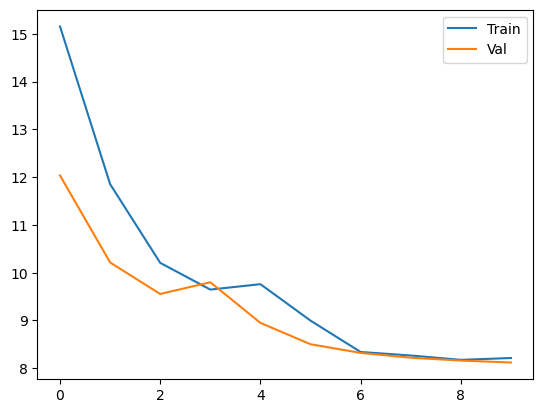

In [30]:
history_train, history_val = train_function(1000)
history_train_list += history_train
history_val_list += history_val
plt.plot(history_train_list[1::100],label="Train")
plt.plot(history_val_list,label="Val")
plt.legend()
torch.save(model,f"TGAE2_GRUConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

1010/2000: cost 0.8279s train loss 8.1069
1020/2000: cost 0.7846s train loss 8.0836
1030/2000: cost 0.8010s train loss 8.1063
1040/2000: cost 0.7830s train loss 8.1152
1050/2000: cost 0.7922s train loss 8.0877
1060/2000: cost 0.7881s train loss 7.9612
1070/2000: cost 0.8040s train loss 8.0721
1080/2000: cost 0.7995s train loss 8.1142
1090/2000: cost 0.7922s train loss 8.0192
10.589317671775826
1100/2000: cost 2.7596s train loss 8.1784 val loss 8.0854
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.971    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.945    | 0         | 0      |
+-------+----------+-----------+--------+
1110/2000: cost 0.7985s train loss 7.9991
1120/2000: cost 0.7865s train loss 8.0054
1130/2000: cost 0.8179s train loss 8.0608
1140/2000: cost 0.8017s train loss 8.0763
1150/2000: cost 0.7872s train loss 8.0334
1160/2000: cost 0.8123s train loss 7.9986

/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


1300/2000: cost 2.7854s train loss 8.0516 val loss 8.0110
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.965    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
1310/2000: cost 0.7941s train loss 8.0023
1320/2000: cost 0.7928s train loss 7.9918
1330/2000: cost 0.8257s train loss 7.9617
1340/2000: cost 0.7972s train loss 8.0307
1350/2000: cost 0.8016s train loss 7.9708
1360/2000: cost 0.8102s train loss 7.9250
1370/2000: cost 0.7991s train loss 7.9428
1380/2000: cost 0.7861s train loss 8.0566
1390/2000: cost 0.7917s train loss 8.0198
12.50246522235892


/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


1400/2000: cost 2.8219s train loss 7.9777 val loss 7.9891
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.967    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
1410/2000: cost 0.8387s train loss 7.7801
1420/2000: cost 0.8007s train loss 7.8888
1430/2000: cost 0.8474s train loss 7.9999
1440/2000: cost 0.7910s train loss 8.0006
1450/2000: cost 0.7874s train loss 8.0501
1460/2000: cost 0.7906s train loss 8.0116
1470/2000: cost 0.8229s train loss 7.9878
1480/2000: cost 0.7903s train loss 8.0086
1490/2000: cost 0.7930s train loss 7.9692
10.133889250755328
1500/2000: cost 2.8221s train loss 7.9319 val loss 7.9872
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.969    | 0         | 0      |
+-------+----------+-----

/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


1600/2000: cost 2.8527s train loss 7.9562 val loss 7.9647
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.958    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
1610/2000: cost 0.9038s train loss 7.8954
1620/2000: cost 0.8047s train loss 7.8886
1630/2000: cost 0.7925s train loss 7.9318
1640/2000: cost 0.7869s train loss 7.9554
1650/2000: cost 0.7988s train loss 7.9664
1660/2000: cost 0.7821s train loss 7.9774
1670/2000: cost 0.7880s train loss 7.9665
1680/2000: cost 0.7943s train loss 7.9170
1690/2000: cost 0.8290s train loss 7.9395
10.95465607738495


/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


1700/2000: cost 2.8680s train loss 7.9901 val loss 8.0000
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.967    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
1710/2000: cost 0.8039s train loss 7.9665
1720/2000: cost 0.8153s train loss 7.8550
1730/2000: cost 0.8128s train loss 7.9410
1740/2000: cost 0.8084s train loss 7.8840
1750/2000: cost 0.7857s train loss 7.9491
1760/2000: cost 0.7884s train loss 7.9740
1770/2000: cost 0.8044s train loss 7.8535
1780/2000: cost 0.7927s train loss 7.8316
1790/2000: cost 0.7872s train loss 7.9669
13.197608894348285


/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


1800/2000: cost 2.8998s train loss 7.8244 val loss 7.9377
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.975    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
1810/2000: cost 0.7870s train loss 7.8413
1820/2000: cost 0.8073s train loss 7.9256
1830/2000: cost 0.7891s train loss 7.9329
1840/2000: cost 0.8043s train loss 7.8992
1850/2000: cost 0.7895s train loss 7.9260
1860/2000: cost 0.7890s train loss 7.9919
1870/2000: cost 0.7946s train loss 7.9413
1880/2000: cost 0.7924s train loss 7.9544
1890/2000: cost 0.8240s train loss 7.9791
10.519566793441774
1900/2000: cost 2.8543s train loss 7.8894 val loss 7.9358
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.975    | 0         | 0      |
+-------+----------+-----

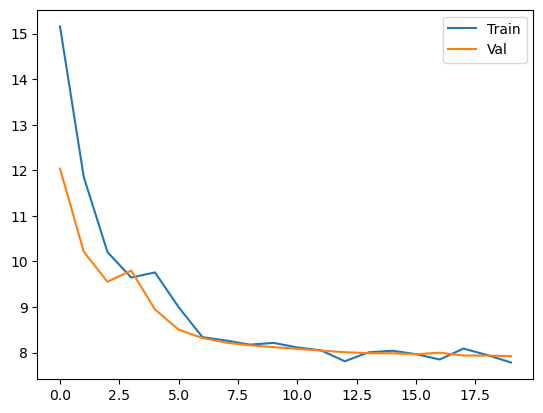

In [31]:
history_train, history_val = train_function(1000)
history_train_list += history_train
history_val_list += history_val
plt.plot(history_train_list[1::100],label="Train")
plt.plot(history_val_list,label="Val")
plt.legend()
torch.save(model,f"TGAE2_GRUConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

2010/3000: cost 0.7887s train loss 7.8697
2020/3000: cost 0.7885s train loss 7.9414
2030/3000: cost 0.7833s train loss 7.8822
2040/3000: cost 0.7942s train loss 7.9600
2050/3000: cost 0.7825s train loss 8.0136
2060/3000: cost 0.7913s train loss 7.9309
2070/3000: cost 1.0010s train loss 7.7999
2080/3000: cost 0.8067s train loss 7.9291
2090/3000: cost 0.8128s train loss 7.7976
12.701423015594589


/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


2100/3000: cost 2.8340s train loss 7.9106 val loss 7.9232
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.965    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
2110/3000: cost 0.7916s train loss 7.8976
2120/3000: cost 0.7969s train loss 7.9144
2130/3000: cost 0.7868s train loss 7.9529
2140/3000: cost 0.9941s train loss 7.8836
2150/3000: cost 0.7966s train loss 7.9698
2160/3000: cost 0.7800s train loss 7.8757
2170/3000: cost 0.8122s train loss 7.8158
2180/3000: cost 0.8210s train loss 7.6976
2190/3000: cost 0.7945s train loss 7.9366
12.440220171928516


/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


2200/3000: cost 2.8036s train loss 7.7255 val loss 7.9191
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.967    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
2210/3000: cost 0.9538s train loss 7.9488
2220/3000: cost 0.7877s train loss 7.8703
2230/3000: cost 0.7800s train loss 7.8838
2240/3000: cost 0.8048s train loss 7.8592
2250/3000: cost 0.7940s train loss 7.8901
2260/3000: cost 0.8410s train loss 7.8957
2270/3000: cost 0.7901s train loss 7.8516
2280/3000: cost 0.7939s train loss 7.8186
2290/3000: cost 0.7835s train loss 7.8565
12.160818759918444


/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


2300/3000: cost 2.9316s train loss 7.9079 val loss 7.9052
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.965    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
2310/3000: cost 0.7836s train loss 7.8597
2320/3000: cost 0.7953s train loss 7.9280
2330/3000: cost 0.7880s train loss 7.8625
2340/3000: cost 0.7848s train loss 17.3958
2350/3000: cost 0.8358s train loss 14.0620
2360/3000: cost 0.7948s train loss 11.8948
2370/3000: cost 0.7848s train loss 11.2152
2380/3000: cost 0.7948s train loss 10.6581
2390/3000: cost 0.7927s train loss 10.2160
16.05277846145644


/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


2400/3000: cost 2.8110s train loss 10.0408 val loss 10.0241
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.975    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
2410/3000: cost 0.7989s train loss 9.9202
2420/3000: cost 0.7910s train loss 9.7827
2430/3000: cost 0.8049s train loss 9.6139
2440/3000: cost 0.8226s train loss 9.8267
2450/3000: cost 0.7840s train loss 9.6441
2460/3000: cost 0.8025s train loss 9.4777
2470/3000: cost 0.7952s train loss 9.5118
2480/3000: cost 0.8166s train loss 9.2723
2490/3000: cost 0.7890s train loss 9.3842
15.079919130325738


/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


2500/3000: cost 2.8171s train loss 9.3162 val loss 9.2841
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.973    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
2510/3000: cost 0.7850s train loss 9.2276
2520/3000: cost 0.8104s train loss 9.0862
2530/3000: cost 0.8218s train loss 9.0347
2540/3000: cost 0.8439s train loss 9.0052
2550/3000: cost 0.8209s train loss 8.8803
2560/3000: cost 0.7875s train loss 9.0169
2570/3000: cost 0.7909s train loss 8.9112
2580/3000: cost 0.7938s train loss 8.9428
2590/3000: cost 0.8103s train loss 8.8958
14.415677330971098


/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


2600/3000: cost 3.1394s train loss 8.8506 val loss 8.8738
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.969    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
2610/3000: cost 0.7814s train loss 8.8315
2620/3000: cost 0.7995s train loss 8.8611
2630/3000: cost 0.8448s train loss 8.7966
2640/3000: cost 0.7975s train loss 8.7296
2650/3000: cost 0.8054s train loss 8.9728
2660/3000: cost 0.7886s train loss 8.9633
2670/3000: cost 0.8011s train loss 8.7612
2680/3000: cost 0.7919s train loss 8.8052
2690/3000: cost 0.7850s train loss 8.7293
11.51996607685091
2700/3000: cost 2.7966s train loss 8.6859 val loss 8.7555
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.967    | 0         | 0      |
+-------+----------+------

/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


3000/3000: cost 2.8339s train loss 8.1335 val loss 8.1542
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.979    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+


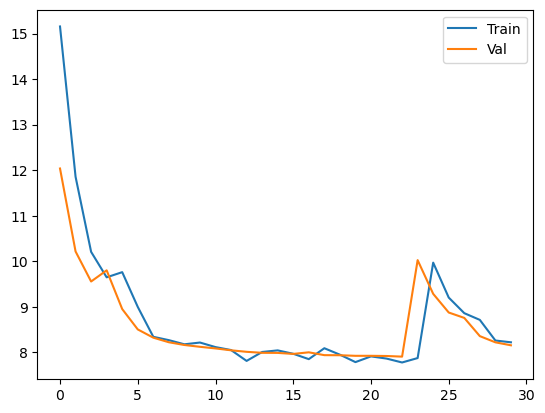

In [32]:
history_train, history_val = train_function(1000)
history_train_list += history_train
history_val_list += history_val
plt.plot(history_train_list[1::100],label="Train")
plt.plot(history_val_list,label="Val")
plt.legend()
torch.save(model,f"TGAE2_GRUConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

3010/4000: cost 0.7924s train loss 8.1545
3020/4000: cost 0.7965s train loss 8.0898
3030/4000: cost 0.8040s train loss 7.9838
3040/4000: cost 0.7907s train loss 8.1034
3050/4000: cost 0.7847s train loss 8.1058
3060/4000: cost 0.8315s train loss 8.0293
3070/4000: cost 0.7848s train loss 8.0836
3080/4000: cost 0.7997s train loss 8.1743
3090/4000: cost 0.8166s train loss 7.9839
10.683621712684634
3100/4000: cost 2.8492s train loss 8.1331 val loss 8.1157
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.958    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.953    | 0         | 0      |
+-------+----------+-----------+--------+
3110/4000: cost 0.9817s train loss 7.9836
3120/4000: cost 0.7945s train loss 8.1372
3130/4000: cost 0.8185s train loss 7.9259
3140/4000: cost 0.7985s train loss 7.9891
3150/4000: cost 0.7802s train loss 8.1310
3160/4000: cost 0.7868s train loss 8.0812

/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


3300/4000: cost 2.8620s train loss 8.0712 val loss 8.0614
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.963    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
3310/4000: cost 0.7870s train loss 8.0934
3320/4000: cost 0.7982s train loss 8.0454
3330/4000: cost 0.8051s train loss 8.0923
3340/4000: cost 1.0028s train loss 8.0142
3350/4000: cost 0.8106s train loss 8.0589
3360/4000: cost 0.8140s train loss 8.0682
3370/4000: cost 0.8059s train loss 7.9932
3380/4000: cost 0.9720s train loss 8.0852
3390/4000: cost 0.8504s train loss 8.0178
13.879252448082095


/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


3400/4000: cost 2.8737s train loss 7.9130 val loss 8.0581
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.971    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
3410/4000: cost 0.9662s train loss 7.9388
3420/4000: cost 0.8170s train loss 7.8930
3430/4000: cost 0.8006s train loss 8.0335
3440/4000: cost 0.7900s train loss 8.0143
3450/4000: cost 0.7851s train loss 8.0348
3460/4000: cost 0.8289s train loss 7.9541
3470/4000: cost 0.8177s train loss 7.9662
3480/4000: cost 0.7996s train loss 7.9862
3490/4000: cost 0.8220s train loss 7.9261
10.609018313407903
3500/4000: cost 2.8209s train loss 8.0392 val loss 8.0384
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.971    | 0         | 0      |
+-------+----------+-----

/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


4000/4000: cost 2.8234s train loss 7.9733 val loss 7.9965
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.971    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+


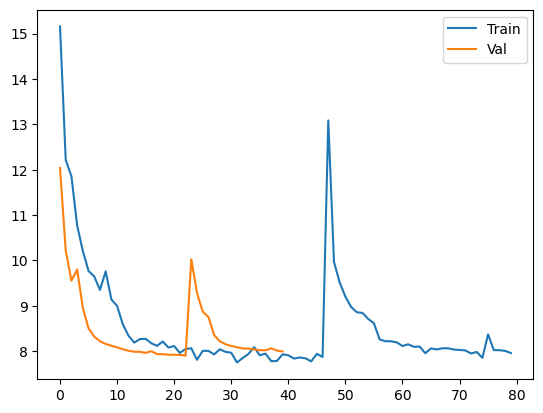

In [33]:
history_train, history_val = train_function(1000)
history_train_list += history_train
history_val_list += history_val
plt.plot(history_train_list[1::50],label="Train")
plt.plot(history_val_list,label="Val")
plt.legend()
torch.save(model,f"TGAE2_GRUConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

4010/5000: cost 0.8457s train loss 8.0360
4020/5000: cost 0.7899s train loss 7.9689
4030/5000: cost 0.8772s train loss 8.0327
4040/5000: cost 0.7953s train loss 7.9812
4050/5000: cost 0.7923s train loss 7.9927
4060/5000: cost 0.7861s train loss 7.8637
4070/5000: cost 0.7907s train loss 7.9807
4080/5000: cost 0.7861s train loss 7.9909
4090/5000: cost 0.7795s train loss 7.9859
10.601603094100954
4100/5000: cost 3.2734s train loss 7.9453 val loss 7.9929
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.967    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.949    | 0         | 0      |
+-------+----------+-----------+--------+
4110/5000: cost 0.8030s train loss 8.0203
4120/5000: cost 0.7904s train loss 7.9520
4130/5000: cost 0.7872s train loss 8.0054
4140/5000: cost 0.7872s train loss 8.0403
4150/5000: cost 0.7848s train loss 7.9876
4160/5000: cost 0.8006s train loss 8.0213

/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


4400/5000: cost 2.7695s train loss 7.8906 val loss 7.9739
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.967    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
4410/5000: cost 0.7961s train loss 7.8997
4420/5000: cost 0.9960s train loss 7.9455
4430/5000: cost 0.8055s train loss 7.9444
4440/5000: cost 0.7874s train loss 7.9168
4450/5000: cost 0.8104s train loss 7.9586
4460/5000: cost 0.7969s train loss 7.9304
4470/5000: cost 0.7917s train loss 7.9589
4480/5000: cost 0.7972s train loss 7.8062
4490/5000: cost 0.8011s train loss 7.9209
11.43108520698559


/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


4500/5000: cost 2.7826s train loss 7.8044 val loss 7.9533
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.975    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
4510/5000: cost 0.7862s train loss 7.8903
4520/5000: cost 0.8162s train loss 7.8571
4530/5000: cost 0.7982s train loss 7.8888
4540/5000: cost 0.7772s train loss 7.9020
4550/5000: cost 0.7864s train loss 7.9548
4560/5000: cost 0.8076s train loss 7.7626
4570/5000: cost 0.7912s train loss 7.9532
4580/5000: cost 0.8068s train loss 7.8329
4590/5000: cost 0.7847s train loss 7.9457
10.562936511039736
4600/5000: cost 2.8954s train loss 7.9391 val loss 7.9530
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.950    | 0         | 0      |
+-------+----------+-----

/tmp/ipykernel_29/4192445464.py:56: RuntimeWarning: invalid value encountered in long_scalars
  val_precision = tp/(tp+fp)


4900/5000: cost 2.7745s train loss 7.9128 val loss 7.9398
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.963    | 0         | 0      |
+-------+----------+-----------+--------+
| Val   | 0.957    | nan       | 0      |
+-------+----------+-----------+--------+
4910/5000: cost 0.7869s train loss 7.9159
4920/5000: cost 0.7936s train loss 7.9758
4930/5000: cost 0.7879s train loss 7.9449
4940/5000: cost 0.7790s train loss 7.9287
4950/5000: cost 0.7863s train loss 7.8874
4960/5000: cost 0.7871s train loss 7.9605
4970/5000: cost 0.8076s train loss 7.8866
4980/5000: cost 0.7867s train loss 7.8991
4990/5000: cost 0.8023s train loss 7.9378
10.534387592315674
5000/5000: cost 2.7401s train loss 7.9192 val loss 7.9177
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.958    | 0         | 0      |
+-------+----------+-----

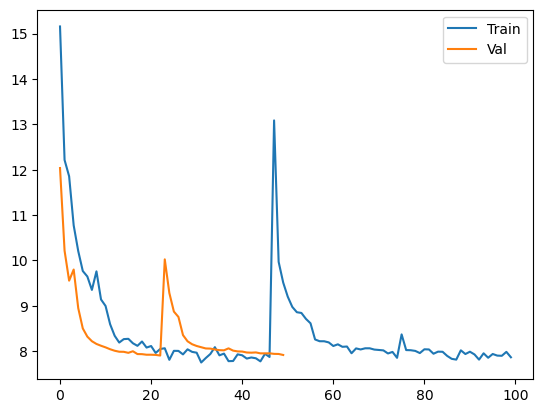

In [34]:
history_train, history_val = train_function(1000)
history_train_list += history_train
history_val_list += history_val
plt.plot(history_train_list[1::50],label="Train")
plt.plot(history_val_list,label="Val")
plt.legend()
torch.save(model,f"TGAE2_GRUConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

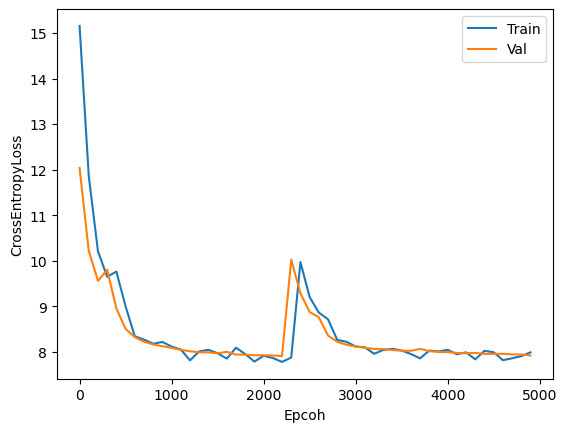

In [50]:

plt.plot(history_train_list[1::100],label="Train")
plt.plot(history_val_list,label="Val")
plt.xticks(np.arange(0,len(history_val_list)+1,10), np.arange(0,len(history_val_list)*100+1,1000))
plt.ylabel("CrossEntropyLoss")
plt.xlabel("Epcoh")
plt.legend()
plt.savefig(f'InnerProductDecoder_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.png')

In [40]:
history_dict = {
    'train': history_train_list,
    'val': history_val_list
}
import pickle
with open("history.pickle", "wb") as f:
    pickle.dump(history_dict,f)

In [41]:
with open("history.pickle", "rb") as f:
    history_dict = pickle.load(f)
print(history_dict)

{'train': [14.790428, 15.155201, 14.996518, 14.794355, 14.18415, 13.96552, 13.694402, 13.6605215, 13.541235, 13.277349, 13.403695, 13.106619, 13.29363, 13.187542, 13.144145, 12.834341, 13.036134, 12.860346, 12.953465, 12.796758, 12.690034, 12.557687, 12.614053, 12.313593, 12.487544, 12.484257, 12.57598, 12.508478, 12.52132, 12.526982, 12.40642, 12.466599, 12.502988, 12.47179, 12.441663, 12.411465, 12.343312, 12.347522, 12.479855, 12.482848, 12.154582, 12.282048, 12.31548, 12.312462, 12.164367, 12.135242, 12.287366, 12.257903, 12.273717, 12.291397, 12.192416, 12.213653, 12.171817, 12.1339, 12.155581, 12.141821, 12.151521, 11.931313, 12.209542, 12.204306, 11.771362, 12.10891, 12.013071, 12.077828, 11.78451, 12.106151, 11.958257, 12.008593, 12.053359, 12.046816, 12.098528, 12.005692, 11.859741, 11.918696, 12.038657, 11.930116, 12.006616, 11.983822, 11.988282, 11.982962, 11.881735, 11.970843, 11.871404, 11.858292, 11.66466, 11.793389, 11.814286, 11.934179, 11.673, 11.651187, 11.546925, 11.

In [ ]:
# history_train, history_val = train_function(50)
# history_train_list += history_train
# history_val_list += history_val
# plt.plot(history_train_list[1::5],label="Train")
# plt.plot(history_val_list,label="Val")
# plt.legend()

# Evaluation

In [ ]:
batch_signal = BatchSignal(signals=signals_train, batch_size=BATCH_SIZE, seq_len=MIN_LEN).to(device)
# batch_node_losses = test_loop(batch_signal, model, loss_f, optimizer, device, split_loss=True)
# np.percentile(np.concatenate(batch_node_losses), 99.9) 

In [ ]:
batch_signal.batch_inc_dict[0]['edge_index']

In [ ]:
counts, edges, bars = plt.hist(np.concatenate(batch_node_losses),bins=20)
plt.bar_label(bars)
plt.show()

In [ ]:
snapshot_losses_list = []
for i_signal, signal in enumerate(signals_train):
    signal.to(device)
    snapshot_losses = test_loop(signal, model, loss_f, optimizer, device, split_loss=True)
    snapshot_losses_list.append(snapshot_losses)

In [ ]:
anomaly_threshold = np.percentile(np.concatenate(snapshot_losses_list), 99) 
print(anomaly_threshold)
tn, fp, fn, tp = 0, 0, 0, 0
for signal, snapshot_losses in zip(signals_train,snapshot_losses_list):
    _tn, _fp, _fn, _tp = signal_graph_eval_func(signal, snapshot_losses, anomaly_threshold)
    tn += _tn; fp += _fp; fn += _fn; tp += _tp
train_accuracy = (tn+tp)/(tn+fp+fn+tp)
train_precision = tp/(tp+fp)
train_recall = tp/(tp+fn)

print(train_accuracy, train_precision, train_recall)
print(tn, fp, fn, tp)

In [ ]:
snapshot_losses_list = []
for i_signal, signal in enumerate(signals_val):
    signal.to(device)
    snapshot_losses = test_loop(signal, model, loss_f, optimizer, device, split_loss=True)
    snapshot_losses_list.append(snapshot_losses)

In [ ]:
fig = plt.figure(figsize=(20,20))    
for i_signal,(signal, snapshot_losses, annotation) in enumerate(zip(signals_val, snapshot_losses_list, annotation_val)):
    ts_list = signal.ts_list
    plt.subplot(len(signals_val)+1,1,i_signal+1)
#     print(len(snapshot_losses))
    plt.plot(ts_list,[np.max(loss) for loss in snapshot_losses])
    for ts, label in zip(ts_list, signal.y):
        if label == 1:
            plt.axvline(x = ts, color = 'black', ls='--')
    if annotation[0] == 'dos':
        plt.axvline(x = float(annotation[1]), color = 'red', label = annotation[0])
    if annotation[0] == 'privesc':
        plt.axvline(x = float(annotation[1]), color = 'blue', label = annotation[0])

In [ ]:
for signal, snapshot_losses in zip(signals_val, snapshot_losses_list):
#     print(snapshot_losses)
    print([(i_snapshot, len(loss),int(label)) for i_snapshot, (loss, label) in enumerate(zip(snapshot_losses, signal.y))])
    loss_list = []
    for losses in snapshot_losses:
        loss_list += list(losses)
    counts, edges, bars = plt.hist(loss_list)
    plt.bar_label(bars)
    plt.show()
    break
    

In [ ]:
counts, edges, bars = plt.hist(snapshot_losses_list[0][5],bins=20)
plt.bar_label(bars)
plt.show()

In [ ]:
counts, edges, bars = plt.hist(snapshot_losses_list[0][11],bins=20)
plt.bar_label(bars)
plt.show()

In [ ]:
# history_train, history_val = train_function(50)
# history_train_list += history_train
# history_val_list += history_val
# plt.plot(history_train_list[1::5],label="Train")
# plt.plot(history_val_list,label="Val")
# plt.legend()

In [ ]:
# fig = plt.figure(figsize=(20,20))    
# for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
#     snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
# #                 print(np.mean(val_loss))
# #     val_losses.append(np.mean(snapshot_losses))
#     ts_list = signal.ts_list
#     plt.subplot(len(signals_val)+1,1,i_signal+1)
# #     print(len(snapshot_losses))
#     plt.plot(ts_list,[np.max(loss) for loss in snapshot_losses])
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# # plt.show()
# plt.savefig(f'val_res_TGAE_NNConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.png')

In [ ]:
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], use_cuda=True, record_shapes=True) as prof:
#         history_train, history_val = train_function(1)
#         history_train_list += history_train
#         history_val_list += history_val
#         plt.plot(history_train_list[1::5],label="Train")
#         plt.plot(history_val_list,label="Val")
#         plt.legend()
# print(prof.key_averages().table(sort_by="cuda_time_total"))

In [ ]:
# print(prof.key_averages().table(sort_by="cpu_time_total"))

In [ ]:
# fig = plt.figure(figsize=(20,20))    
# for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
#     snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
# #                 print(np.mean(val_loss))
# #     val_losses.append(np.mean(snapshot_losses))
#     ts_list = signal.ts_list
#     plt.subplot(len(signals_val)+1,1,i_signal+1)
# #     print(len(snapshot_losses))
#     plt.plot(ts_list,snapshot_losses[:-1])
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# # plt.show()
# plt.savefig('val_res.png')

In [ ]:
# torch.save(model,f"{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

In [ ]:
# history_train, history_val = train_function(100)
# history_train_list += history_train
# history_val_list += history_val
# plt.plot(history_train_list[1::5],label="Train")
# plt.plot(history_val_list,label="Val")
# plt.legend()

In [ ]:
# states_encoder_val = []
# states_decoder_val = []
# for num_node in nums_node_val:
#     states_encoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.gnn_out_channels))
#     states_decoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.embedding_hidden_nums[-1]))    

# fig = plt.figure(figsize=(20,20))    
# for i_sample, (sample, y, hidden_encoder_global, hidden_decoder_global) in enumerate(zip(X_val, y_val, states_encoder_val, states_decoder_val)):
#     val_loss = test_loop(sample, hidden_encoder_global, hidden_decoder_global, model, loss_f, optimizer, device)
#     # print(np.mean(val_loss))
#     ts_list = [snapshot.timestamp for snapshot in sample]
#     plt.subplot(len(X_val)+1,1,i_sample+1)
#     plt.plot(ts_list,val_loss)
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# plt.show()